In [ ]:
!pip install -q pydicom

     |████████████████████████████████| 35.5MB 101kB/s 


In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from google.colab import drive

drive.mount ('/content/drive')

INPUT_FOLDER = '/content/drive/My Drive/chest CT/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices



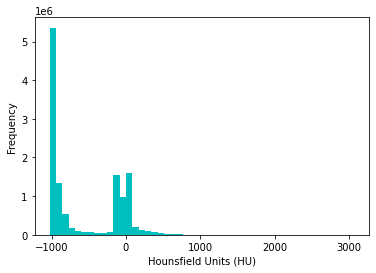

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=48, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()



In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])    



In [ ]:
def plot_3d(image, elevation, LL, UL, threshold=-300):
  for rotate in range(LL, UL):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
      p = image.transpose(2,1,0)
    
      verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)

      fig = plt.figure(figsize=(10, 8), dpi=2400)
      ax = fig.add_subplot(111, projection='3d')

    # verts[faces] to generate a collection of triangles
      mesh = Poly3DCollection(verts[faces], alpha=0.70)
      face_color = [0.45, 0.45, 0.75]
      mesh.set_facecolor(face_color)
      ax.add_collection3d(mesh)

      ax.set_xlim(0, p.shape[0])
      ax.set_ylim(0, p.shape[1])
      ax.set_zlim(0, p.shape[2])
      plt.axis('off')
      plt.grid(b=None)
      ax.view_init(elevation, rotate)
      images_dir = '/content/drive/My Drive/Images/sub-3/'
      fig.savefig(f"{images_dir}subject-3-({rotate}).jpg", Transparent = True)

      plt.show(fig)

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    background_label = labels[0,0,0]
    
    binary_image[background_label == labels] = 2
    
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

      

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)    

In [ ]:
plot_3d(segmented_lungs, 0, 105, 361, 0)